# Cryogenic Pump Feature Engineering
Jared Nielsen

In [194]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook


plt.rcParams['figure.figsize'] = 15,3
blue = '#1f77b4'
pd.set_option('precision', 2)

In [195]:
os.getcwd()

'/mnt/pccfs/backed_up/jaredtn/cryopumps'

## Load the Cleaned Data

In [174]:
data_folder = '/mnt/pccfs/backed_up/jaredtn/data/'
cryo_csv = data_folder+'cryos_cleaned.csv'
turbo_csv = data_folder+'turbos_cleaned.csv'

start = datetime.now()
x_cryo = pd.read_csv(cryo_csv, parse_dates=['timestamp'])
elapsed = (datetime.now() - start).total_seconds()

print("Cryos Shape: {}".format(x_cryo.shape))
print("Time: {}".format(elapsed))

start = datetime.now()
x_turbo = pd.read_csv(turbo_csv, parse_dates=['timestamp'])
elapsed = (datetime.now() - start).total_seconds()

print("Turbos Shape: {}".format(x_turbo.shape))
print("Time: {}".format(elapsed))

Cryos Shape: (2018168, 8)
Time: 2.019876
Turbos Shape: (412601, 8)
Time: 0.42244


## Samples

In [4]:
x_cryo.head()

,unitsequence,timestamp,temp1,temp2,heater1,heater2,tcpressure,currentregen
0,17798282,2018-04-10 14:57:00,65.0,12.2,1.0,0.0,0.5,P
1,17798282,2018-04-10 14:58:00,65.0,12.1,1.0,0.0,0.5,P
2,17798282,2018-04-10 14:59:00,65.0,12.2,1.0,0.0,0.5,P
3,17798282,2018-04-10 15:00:00,64.9,12.2,1.0,0.0,0.5,P
4,17798282,2018-04-10 15:01:00,64.9,12.1,1.0,0.0,0.5,P


In [5]:
x_turbo.head()

,unitsequence,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent
0,16775261,2018-04-10 14:57:00,2.0,13.0,545.0,147.0,122.0,0.4
1,16775261,2018-04-10 14:58:00,2.0,13.0,545.0,147.0,122.0,0.5
2,16775261,2018-04-10 14:59:00,2.0,13.0,545.0,147.0,122.0,0.5
3,16775261,2018-04-10 15:00:00,2.0,13.0,545.0,147.0,122.0,0.5
4,16775261,2018-04-10 15:01:00,2.0,13.0,545.0,147.0,122.0,0.5


## Initial Visualization

Experiments have shown that turbos have data with more variation than cryos, so we start our analysis by looking at turbo pumps.  

Let's pick the turbo pump that has the longest-running interval and analyze it.  
Try `unitsequence = 16775261`. This has `37,924` elements.  

So there are correlations going on, though they're extremely obvious. Motor speed corresponds with motor temperature - who knew? There's a lot of feature engineering to be done here, but the data is clean and ready.  

In [175]:
def get_unitsequences(x_subset):
    return x_subset['unitsequence'].unique()

def get_pump(x_subset, unitsequence):
    return x_subset[x_subset['unitsequence'] == unitsequence]

def get_intervals(x_pump):
    """
    Parameters:
        x_pump (DataFrame): output of get_pump().
    Returns:
        intervals (list(DataFrame)): the DataFrame intervals, ordered by time.
    """
    x_pump_sorted = x_pump.sort_values("timestamp").copy()
    interval_desc = (x_pump_sorted["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    intervals = [v for k,v in x_pump_sorted.groupby(interval_desc)]
    return intervals

def plot_interval(interval, val_names, title=None):
    interval.plot(x='timestamp', y=val_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=3, figsize=(20,10))
    if title:
        plt.suptitle(title)
    plt.show()

In [176]:
turbo_cols = list(x_turbo)
print(turbo_cols)
us = 16775261 # turbo unit_sequence
unique_us = get_unitsequences(x_turbo)
print(unique_us)

pump = x_turbo[x_turbo['unitsequence'] == us] # single turbo pump
pump.head()

['unitsequence', 'timestamp', 'uppervalue', 'lowervalue', 'rotorspeed', 'controllertemp', 'dcvoltage', 'motorcurrent']
[16775261 16775765 16775766 17337958 17339051 16776829 16776830 16776263
 17337512 17337419 16776262]


,unitsequence,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent
0,16775261,2018-04-10 14:57:00,2.0,13.0,545.0,147.0,122.0,0.4
1,16775261,2018-04-10 14:58:00,2.0,13.0,545.0,147.0,122.0,0.5
2,16775261,2018-04-10 14:59:00,2.0,13.0,545.0,147.0,122.0,0.5
3,16775261,2018-04-10 15:00:00,2.0,13.0,545.0,147.0,122.0,0.5
4,16775261,2018-04-10 15:01:00,2.0,13.0,545.0,147.0,122.0,0.5


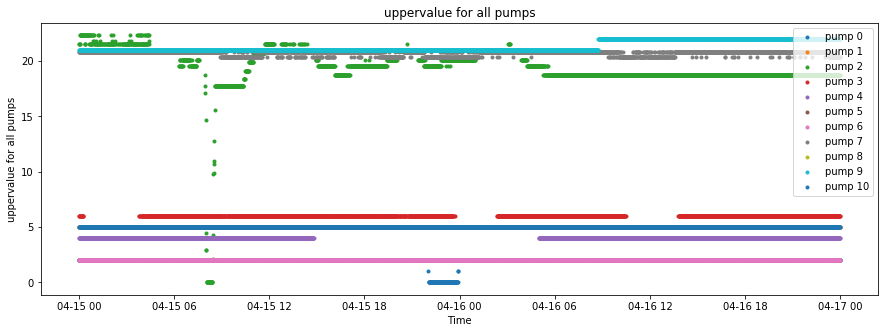

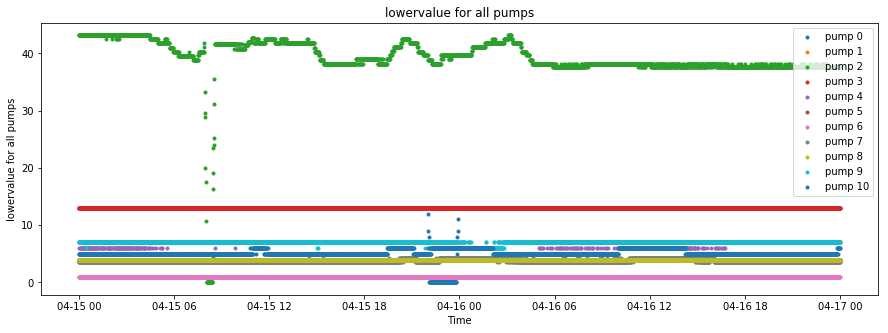

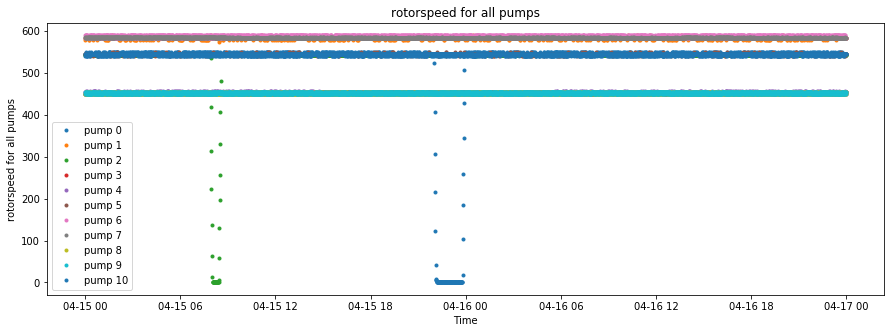

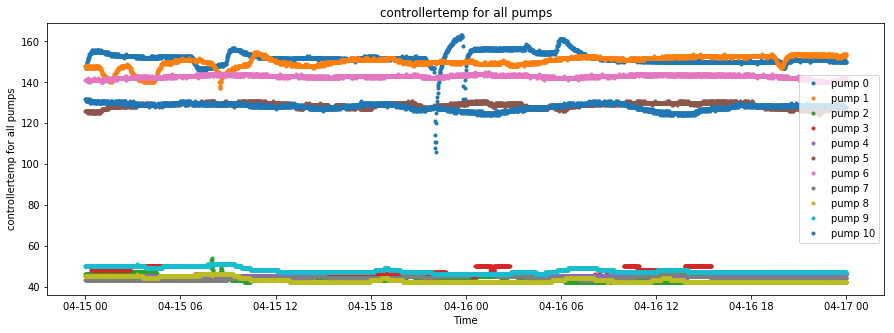

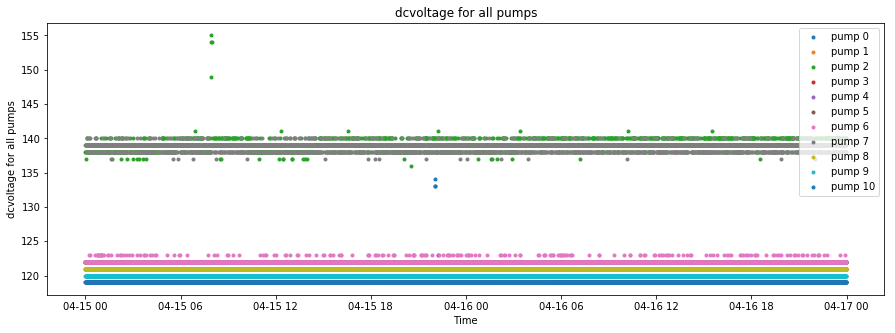

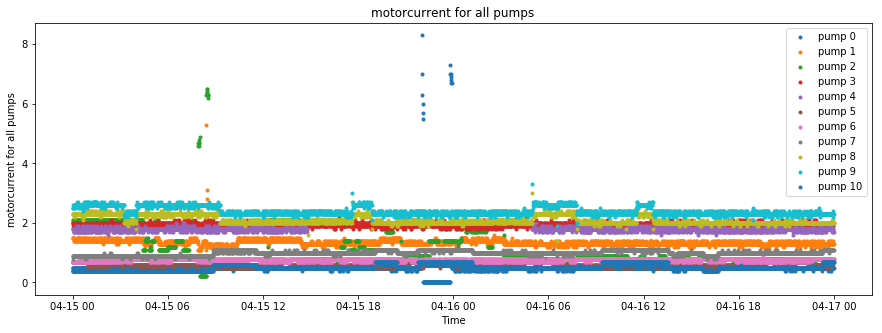

In [197]:
def plot_over_time(t, y, desc):
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.plot(t, y, 'o')
    ax.set_xlabel("Time")
    ax.set_ylabel(desc)
    ax.set_title(desc)
    plt.show()
    
def plot_over_time_many(ts, ys, labels, desc):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    for t, y, label in zip(ts, ys, labels):
        ax.plot(t, y, 'o', markersize=3, label=label)
    ax.set_xlabel("Time")
    ax.set_ylabel(desc)
    ax.set_title(desc)
    ax.legend()
    plt.show()

def time_slice(m, dt1 = '2018-04-15 00:00:00', dt2 = '2018-04-17 00:00:00'):
    ms = m[(dt1 <= m['timestamp']) & (m['timestamp'] < dt2)]
    return ms
   
def plot_pump(pump, title):
    n_timesteps, n_cols = pump.shape
#     pump_slice = time_slice(pump)
    pump_slice = pump
    t = pump_slice["timestamp"].values
    cols = ["motorspeed"]

    turbo_cols = ['uppervalue', 'lowervalue', 'rotorspeed', 'controllertemp', 'dcvoltage', 'motorcurrent']
    print(title)
    for col in turbo_cols:
        plot_over_time(t, pump_slice[col].values, col) 
        
def plot_pumps(pumps, feature, title):
    ts = []
    ys = []
    labels = []
    for i, us in enumerate(unique_us):
        x_us = x_turbo[x_turbo.unitsequence == us]
        x_us = time_slice(x_us)
        ts.append(x_us['timestamp'].values)
        ys.append(x_us[feature].values)
        labels.append("pump {}".format(i))
    plot_over_time_many(ts, ys, labels, title)

# for us in unique_us:
#     plot_pump(x_turbo[x_turbo.unitsequence == us], title="Pump {}".format(us))
#     break

for feature in ["uppervalue", "lowervalue", "rotorspeed", "controllertemp", "dcvoltage", "motorcurrent"]:
    plot_pumps(x_turbo, feature, "{} for all pumps".format(feature))

## Clustering Algorithm (Feature Engineering)

We look for time discontinuities greater than 30 minutes and separate into intervals based on that.  

All the clusters for unit_sequence 16775261
No. Clusters: 2


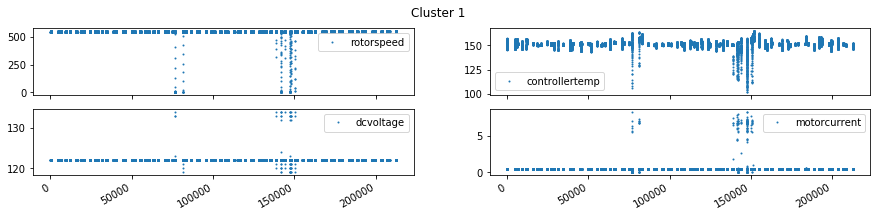

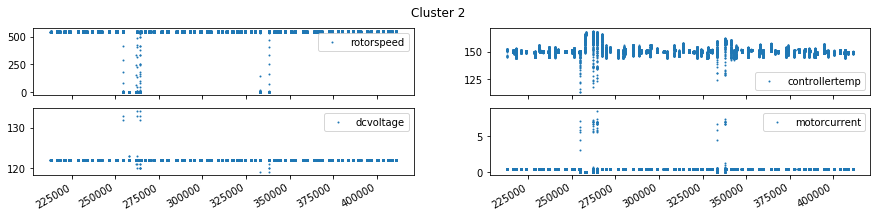

done


In [18]:
def get_clusters(df, unit_sequence_id):
    """
    Parameters:
        unit_sequence_id (int): the id of the pump (fx -18202).
        # col_name (str): the column to extract data for (fx "controllertemp")
    Returns:
        clusters (list(DataFrame)): the DataFrame clusters, ordered by time.
    """
    dfc = df[df["unitsequence"] == unit_sequence_id].sort_values("timestamp").copy()
    cluster = (dfc["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    dfc = [v for k,v in dfc.groupby(cluster)]
    return dfc

def plot_cluster(cluster, col_names, title=None):
    cluster.plot(y=col_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=1)
    if title:
        plt.suptitle(title)
    plt.show()
    
def plot_cluster_magnets(cluster, title=None):
    magcurrents = ["magcurrent{}".format(i) for i in range(9)]
    cluster.plot(y=magcurrents,
                subplots=True, layout=(3,3), marker='o', linestyle='None', color=blue,
                markersize=1, figsize=(10,10))
    if title:
        plt.suptitle(title)
    plt.show()

clusters = get_clusters(pump, us)
col_names = ["rotorspeed", "controllertemp", "dcvoltage", "motorcurrent"]
print("All the clusters for unit_sequence {}".format(us))
print("No. Clusters:", len(clusters))
for i, cluster in enumerate(clusters):
    plot_cluster(cluster, col_names=col_names, title="Cluster {}".format(i+1))
    if i == 1:
        break
        
print("done")

## Linear Regression

Clearly the slopes are all zero. However, the intercepts appear to vary, for example with `rotorspeed`.  
This signifies that `rotorspeed` may be an important feature in unsupervised clustering.  

In [55]:
col_names = ["rotorspeed", "controllertemp", "dcvoltage", "motorcurrent"]
for i, cluster in enumerate(clusters):
    print("Cluster {}".format(i))
    t = np.arange(len(cluster))
    for col in col_names:
        slope, intercept, _, _, _ = stats.linregress(t, cluster[col])
        print("{} - Slope: {:.3f}, Intercept: {:.3f}".format(col, slope, intercept))
    print()

Cluster 0
rotorspeed - Slope: -0.000, Intercept: 541.071
controllertemp - Slope: -0.000, Intercept: 151.051
dcvoltage - Slope: 0.000, Intercept: 122.002
motorcurrent - Slope: 0.000, Intercept: 0.495

Cluster 1
rotorspeed - Slope: 0.003, Intercept: 495.569
controllertemp - Slope: -0.000, Intercept: 151.882
dcvoltage - Slope: -0.000, Intercept: 122.009
motorcurrent - Slope: 0.000, Intercept: 0.487



## Relabel the unitsequences to [0,10]
There are 11 unique unitsequences, so we label them from 0 to 10, inclusive.

In [22]:
len(unique_us)

11

In [49]:
x_turbo.head()

,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent,id
0,2018-04-10 14:57:00,2.0,13.0,545.0,147.0,122.0,0.4,0
1,2018-04-10 14:58:00,2.0,13.0,545.0,147.0,122.0,0.5,0
2,2018-04-10 14:59:00,2.0,13.0,545.0,147.0,122.0,0.5,0
3,2018-04-10 15:00:00,2.0,13.0,545.0,147.0,122.0,0.5,0
4,2018-04-10 15:01:00,2.0,13.0,545.0,147.0,122.0,0.5,0


In [54]:
us_to_id = { us: i for i, us in enumerate(unique_us) }
id_to_us = unique_us
unique_ids = list(range(len(us_to_id)))

if 'unitsequence' in x_turbo:
    x_turbo['id'] = x_turbo['unitsequence'].replace(us_to_id)
    x_turbo.drop('unitsequence', axis=1, inplace=True)

## Break the Clusters Into 64-Element Segments
This corresponds to 1 hour. Can we classify the original pump using 1-D convolutions?

In [123]:
features = ['uppervalue', 'lowervalue', 'rotorspeed', 'controllertemp', 'dcvoltage', 'motorcurrent']
segments = [] # list of dataframes, each 60 timesteps long.
ids = [] # list of ids, corresponds to intervals
batch_size = 64

print(pump.shape)

for pump_id in unique_ids:
    pump = x_turbo[x_turbo['id'] == id_]
    # all batches must be size 64, so skip the end
    for i in range(0, pump.shape[0]-batch_size, batch_size):
        segment = pump.iloc[i:i+batch_size][features].values.T
        segments.append(segment)
        ids.append(pump_id)
        
segments[0].shape

(38188, 8)


(6, 64)

## Define Dataset and DataLoader

In [124]:
class PumpDataset(Dataset):
    """Pump dataset."""

    def __init__(self, segments, ids):
        """
        segments is list of (features, time)
        """
        self._segments = segments
        self._ids = ids

    def __len__(self):
        return len(self._segments)

    def __getitem__(self, idx):
        """
        Returns (batch, channels, length) - i.e. (batch, features, time)
        """
        return self._segments[idx].astype(np.float32), self._ids[idx]

turbo_dataset = PumpDataset(segments, ids)
print("There are {} elements in the dataset.".format(len(turbo_dataset)))

batch_size = 16
turbo_dataloader = DataLoader(turbo_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=4, drop_last=True)

for i, batch in enumerate(turbo_dataloader):
    segment, pump_id = batch
    print("segment: {}".format(segment.shape))
    print("pump_id: {}".format(pump_id.shape))
    break

There are 6556 elements in the dataset.
segment: torch.Size([16, 6, 64])
pump_id: torch.Size([16])


In [172]:
class TurboNet(nn.Module):
    def __init__(self, n_features, n_timesteps, n_classes):
        super().__init__()
        
        self._net = nn.Sequential(
            nn.BatchNorm1d(6),
            # input (n,6,64)
            nn.Conv1d(in_channels=n_features, out_channels=8,
                      kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (n,8,32)
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (n,16,16)
            nn.Conv1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
            # (n,8,8)
        )
        self._linear = nn.Sequential(
            nn.Linear(8*8, n_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self._net(x)
        x = x.view(batch_size, 64)
        x = self._linear(x)
        return x
    

net = TurboNet(n_features=6, n_timesteps=64, n_classes=11)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

n_epochs = 100
loop = tqdm_notebook(total=n_epochs)

for e in range(n_epochs):
    losses = []
    for i, batch in enumerate(turbo_dataloader):
        optimizer.zero_grad()
        segment, pump_id = batch
        pred_id = net(segment)
        loss = criterion(pred_id, pump_id)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    loop.set_description("loss: {:.3f}".format(np.mean(losses)))
    loop.update(1)

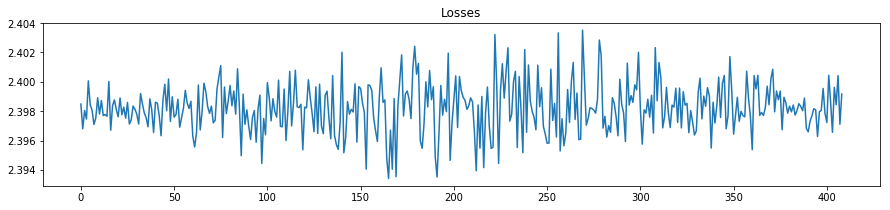

In [191]:
plt.plot(losses)
plt.title("Losses")
plt.show()

The loss is stagnating at 2.398, which happens because the network outputs a uniform distribution over all classes.  
Either our network is not expressive enough or there's not enough information contained to distinguish them.

In [161]:
pump_id # true values

tensor([ 9,  2,  0,  2,  5,  9,  9,  9,  1,  2,  7,  7,  6,  1,
         8,  3])

In [163]:
pred_id.argmax(dim=1) # same prediction every time

tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4])

In [192]:
pred_id[0] # uniform distribution over losses; 4 has a *slight* advantage

tensor([-2.3879, -2.3913, -2.4034, -2.3973, -2.4035, -2.4029, -2.3929,
        -2.3993, -2.4017, -2.4002, -2.3965])